In [1]:
"""
CP322 Mini Project 3
Image Classification Models

Group 15
Authors:
Ratul Sarker:
Jacob Harper : 201830230 : harp0230@mylaurier.ca
Goncalo

"""

'\nCP322 Mini Project 3\nImage Classification Models\n\nGroup 15\nAuthors:\nRatul Sarker:\nJacob Harper : 201830230 : harp0230@mylaurier.ca\nGoncalo\n\n'

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from itertools import product

In [12]:
# Set up Google Colab

# Mount Google Drive (if using Google Colab)
"""
from google.colab import drive
drive.mount('/content/drive')
"""
# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations and load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Define Classes for Models

# Artificial Neural Network (ANN) model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)  # Added hidden layer 1
        self.fc3 = nn.Linear(256, 128)  # Added hidden layer 2
        self.fc4 = nn.Linear(128, 64)   # Added hidden layer 3
        self.fc5 = nn.Linear(64, 10)    # Output layer

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)  # Adding ReLU after hidden layer 1
        x = self.fc3(x)
        x = self.relu(x)  # Adding ReLU after hidden layer 2
        x = self.fc4(x)
        x = self.relu(x)  # Adding ReLU after hidden layer 3
        x = self.fc5(x)   # Output layer
        return x
    

# Convolutional Neural Network (CNN) model
class CNN(nn.Module):
    def __init__(self, num_filters=64, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128 * 8 * 8)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [8]:
# Helper Functions

# Train ANN
def train_ann(model, train_loader, optimizer, criterion, epochs=10):
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


# Train CNN
def train_cnn(model, train_loader, optimizer, criterion, epochs=10):
    for epoch in range(epochs):
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()


# Model Test
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [14]:
# ANN Testing

# Define hyperparameters to test
learning_rates = [0.0003, 0.001, 0.01, 0.03]
batch_sizes = [32, 64, 128]
epochs = [5, 10, 20]

# Create a grid of all hyperparameter combinations
hyperparameter_grid = list(product(learning_rates, batch_sizes, epochs))

# Storage for results
ANNresults = []

for lr, batch_size, num_epochs in hyperparameter_grid:
    # Initialize model and optimizer
    ann_model = ANN().to(device)
    optimizer = optim.SGD(ann_model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Train and test the model
    train_ann(ann_model, train_loader, optimizer, criterion, epochs=num_epochs)
    accuracy = test_model(ann_model, test_loader)

    # Record results
    ANNresults.append((lr, batch_size, num_epochs, accuracy))
    print(f'Completed: LR={lr}, Batch Size={batch_size}, Epochs={num_epochs}, Accuracy={accuracy:.2f}%')


Completed: LR=0.0003, Batch Size=32, Epochs=5, Accuracy=46.63%
Completed: LR=0.0003, Batch Size=32, Epochs=10, Accuracy=49.92%
Completed: LR=0.0003, Batch Size=32, Epochs=20, Accuracy=52.72%
Completed: LR=0.0003, Batch Size=64, Epochs=5, Accuracy=43.72%
Completed: LR=0.0003, Batch Size=64, Epochs=10, Accuracy=46.58%
Completed: LR=0.0003, Batch Size=64, Epochs=20, Accuracy=50.12%
Completed: LR=0.0003, Batch Size=128, Epochs=5, Accuracy=39.40%


KeyboardInterrupt: 

In [ ]:
# Prepare data for plotting
lrs, batch_sizes, epochs, accuracies = zip(*ANNresults)

# Plotting accuracy vs. learning rate for each batch size
plt.figure(figsize=(12, 8))
for batch_size in set(batch_sizes):
    subset = [(lr, acc) for lr, bs, ep, acc in ANNresults if bs == batch_size]
    lrs, accs = zip(*subset)
    plt.plot(lrs, accs, marker='o', label=f'Batch Size: {batch_size}')

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.xscale('log')
plt.title('Model Accuracy for Different Learning Rates and Batch Sizes')
plt.legend()
plt.show()


Learning Rate: 0.0003, Dropout Rate: 0.2, Num Filters: 32, Accuracy: 0.7326
Learning Rate: 0.0003, Dropout Rate: 0.2, Num Filters: 64, Accuracy: 0.7354
Learning Rate: 0.0003, Dropout Rate: 0.2, Num Filters: 128, Accuracy: 0.7287
Learning Rate: 0.0003, Dropout Rate: 0.3, Num Filters: 32, Accuracy: 0.7335
Learning Rate: 0.0003, Dropout Rate: 0.3, Num Filters: 64, Accuracy: 0.7326
Learning Rate: 0.0003, Dropout Rate: 0.3, Num Filters: 128, Accuracy: 0.7313
Learning Rate: 0.0003, Dropout Rate: 0.4, Num Filters: 32, Accuracy: 0.727
Learning Rate: 0.0003, Dropout Rate: 0.4, Num Filters: 64, Accuracy: 0.7319
Learning Rate: 0.0003, Dropout Rate: 0.4, Num Filters: 128, Accuracy: 0.7289
Learning Rate: 0.0003, Dropout Rate: 0.5, Num Filters: 32, Accuracy: 0.7275
Learning Rate: 0.0003, Dropout Rate: 0.5, Num Filters: 64, Accuracy: 0.7193
Learning Rate: 0.0003, Dropout Rate: 0.5, Num Filters: 128, Accuracy: 0.7324
Learning Rate: 0.003, Dropout Rate: 0.2, Num Filters: 32, Accuracy: 0.5793
Learning R

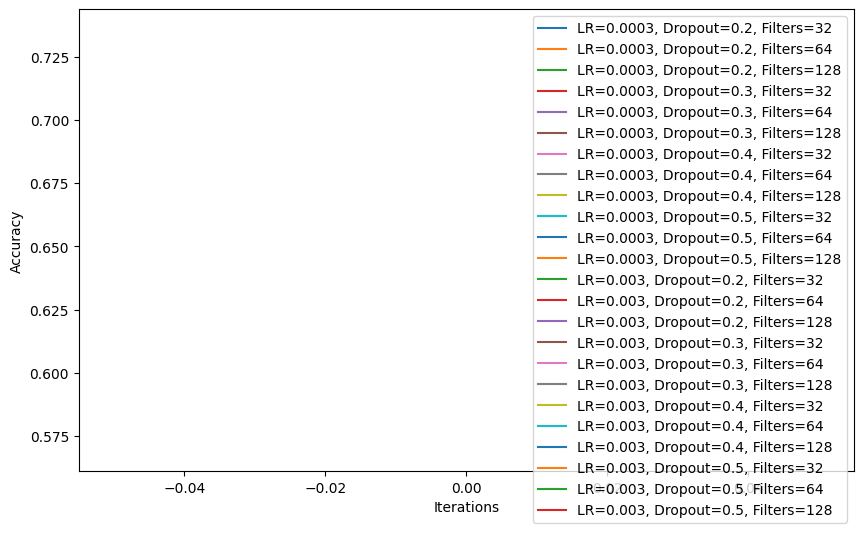

In [15]:
# CNN Testing

# Hyperparameters
learning_rates = [0.0003, 0.0001, 0.003]
dropout_rates = [0.2, 0.5]
num_filters_list = [32, 64, 128]

# Create a grid of all hyperparameter combinations
hyperparameter_grid = list(product(learning_rates, dropout_rates, num_filters_list))

# Storage for results
CNNresults = []

for lr, drop_rate, num_filters in hyperparameter_grid:
    # Initialize model and optimizer
    cnn_model = CNN().to(device)
    optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Train and test the model
    train_ann(ann_model, train_loader, optimizer, criterion)
    accuracy = test_model(cnn_model, test_loader)

    # Record results
    CNNresults.append((lr, batch_size, num_epochs, accuracy))
    print(f'Completed: LR={lr}, Batch Size={batch_size}, Epochs={num_epochs}, Accuracy={accuracy:.2f}%')

IndexError: index 781 is out of bounds for axis 0 with size 3

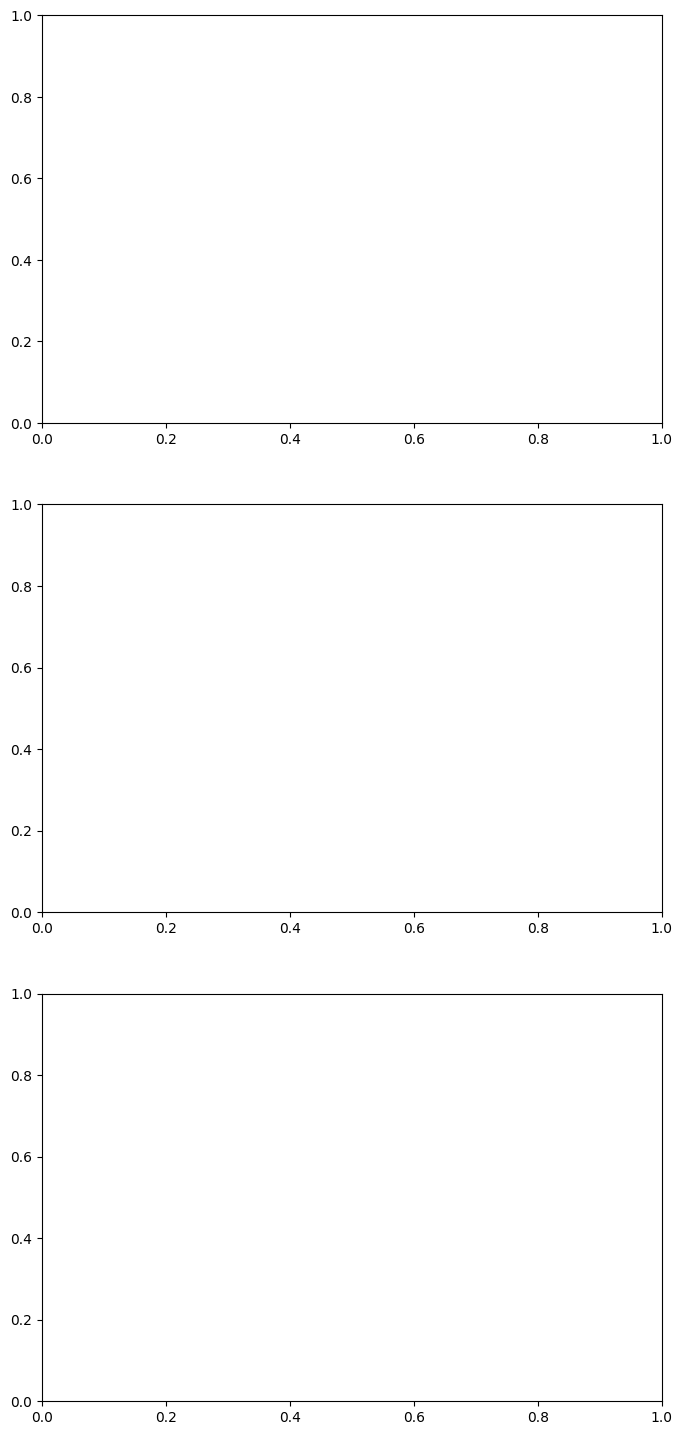

In [7]:
# CNN Graphs

# I have to finish fixing some of this

# Prepare data for plotting
lrs, drop_rates, num_filters, accuracies = zip(*CNNresults)

# Plotting accuracy vs. learning rate for each batch size
plt.figure(figsize=(12, 8))
for batch_size in set(batch_sizes):
    subset = [(lr, acc) for lr, bs, ep, acc in CNNresults if bs == batch_size]
    lrs, accs = zip(*subset)
    plt.plot(lrs, accs, marker='o', label=f'Batch Size: {batch_size}')

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.xscale('log')
plt.title('Model Accuracy for Different Learning Rates and Batch Sizes')
plt.legend()
plt.show()